In [101]:
import pandas as pd

# Đọc dữ liệu gốc từ file CSV
df = pd.read_csv(r'..\data\raw\traffic_accidents.csv')

# Kiểm tra giá trị duy nhất trong cột "damage" để biết có bao nhiêu giá trị
print(df['damage'].value_counts())

# Sử dụng stratified sampling để chia đều các giá trị nhãn "damage"
# Chia đều 500 dòng theo 3 giá trị của nhãn "damage"
random_rows = df.groupby('damage', group_keys=False).apply(lambda x: x.sample(n=500//3, random_state=42))

# In ra các dòng ngẫu nhiên
print(random_rows)

# Lưu các dòng ngẫu nhiên vào một file mới:
random_rows.to_csv('../data/new/new_data.csv', index=False)


damage
OVER $1,500      147313
$501 - $1,500     41210
$500 OR LESS      20783
Name: count, dtype: int64
                    crash_date traffic_control_device weather_condition  \
8323    07/26/2017 07:58:00 PM            NO CONTROLS             CLEAR   
109100  12/13/2019 06:15:00 AM         TRAFFIC SIGNAL             CLEAR   
127292  06/16/2017 03:20:00 PM      STOP SIGN/FLASHER             CLEAR   
195015  09/08/2015 10:44:00 PM         TRAFFIC SIGNAL             CLEAR   
195259  10/08/2018 03:45:00 PM         TRAFFIC SIGNAL             CLEAR   
...                        ...                    ...               ...   
180298  11/21/2019 10:15:00 AM      STOP SIGN/FLASHER              RAIN   
2884    03/30/2024 09:15:00 PM      STOP SIGN/FLASHER             CLEAR   
206173  12/20/2024 03:30:00 PM         TRAFFIC SIGNAL             CLEAR   
23483   03/28/2023 04:55:00 PM      STOP SIGN/FLASHER             CLEAR   
140043  06/10/2022 10:43:00 PM         TRAFFIC SIGNAL   CLOUDY/OVERCAS

C:\Users\QUYEN\AppData\Local\Temp\ipykernel_25672\709215256.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_rows = df.groupby('damage', group_keys=False).apply(lambda x: x.sample(n=500//3, random_state=42))


In [102]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Đọc dataset từ file CSV
df = pd.read_csv(r"..\data\new\new_data.csv", encoding='utf-8') 
print(df['damage'].value_counts())
print(df['damage'].unique())

damage
$500 OR LESS     166
$501 - $1,500    166
OVER $1,500      166
Name: count, dtype: int64
['$500 OR LESS' '$501 - $1,500' 'OVER $1,500']


In [103]:
# Xóa cột "crash_date" nếu tồn tại
if "crash_date" in df.columns:
    df = df.drop(columns=["crash_date"])

true_labels = df['damage'].values

if "damage" in df.columns:
    df = df.drop(columns=["damage"])

# Các cột cần mã hóa
categorical_columns = [
    "traffic_control_device", "weather_condition", "lighting_condition", "first_crash_type", 
    "trafficway_type", "alignment", "roadway_surface_cond", "road_defect", "crash_type", 
    "intersection_related_i", "prim_contributory_cause", "most_severe_injury"
]

# Đảm bảo thư mục chứa encoder tồn tại
encoder_dir = "../data/preprocess/encoder/"
decoders = {}

# Mã hóa dữ liệu bằng các encoder đã lưu
for col in categorical_columns:
    # Kiểm tra giá trị duy nhất trong cột
    unique_values = df[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

    # Đọc encoder đã lưu từ file .pkl
    encoder_path = os.path.join(encoder_dir, f"{col}_encoder.pkl")
    
    # Kiểm tra nếu encoder tồn tại cho cột đó
    if os.path.exists(encoder_path):
        le = joblib.load(encoder_path)
        
        # Kiểm tra nếu có giá trị lạ không có trong encoder
        valid_values = le.classes_
        invalid_values = [val for val in unique_values if val not in valid_values]
        
        if invalid_values:
            print(f"Cảnh báo: Các giá trị sau không có trong encoder cho cột '{col}': {invalid_values}")
            # Thay thế các giá trị lạ bằng 'UNKNOWN'
            df[col] = df[col].replace(invalid_values, 'UNKNOWN')
        
        # Kiểm tra xem 'UNKNOWN' có trong encoder không, nếu không cần huấn luyện lại encoder
        if 'UNKNOWN' not in valid_values:
            print(f"Cảnh báo: 'UNKNOWN' không có trong encoder của cột '{col}'.")

        # Áp dụng encoder để chuyển đổi dữ liệu
        df[col] = le.transform(df[col].replace('UNKNOWN', valid_values[0]))  # Giả sử thay thế bằng giá trị hợp lệ đầu tiên
        decoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        print(f"Không tìm thấy encoder cho cột '{col}', vui lòng kiểm tra lại.")

# Xuất báo cáo mã hóa
encoding_report = """Báo cáo Mã hóa Categorical Data\n\n"""
for col, mapping in decoders.items():
    encoding_report += f"Cột: {col}\n"
    for key, value in mapping.items():
        encoding_report += f"  {key}: {value}\n"
    encoding_report += "\n"

# Xuất báo cáo mã hoá ra file
report_path = r"..\data\new\new_encoding_report.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(encoding_report)

print(f"Báo cáo mã hóa đã lưu vào: {report_path}")

# Lưu dataset đã mã hóa
df.to_csv('../data//new/new_data_cleaned_origin.csv', index=False)

Unique values in column 'traffic_control_device': ['NO CONTROLS' 'TRAFFIC SIGNAL' 'STOP SIGN/FLASHER' 'UNKNOWN'
 'PEDESTRIAN CROSSING SIGN' 'OTHER' 'OTHER REG. SIGN'
 'RAILROAD CROSSING GATE']
Unique values in column 'weather_condition': ['CLEAR' 'SNOW' 'UNKNOWN' 'RAIN' 'FREEZING RAIN/DRIZZLE' 'CLOUDY/OVERCAST'
 'OTHER' 'SLEET/HAIL' 'FOG/SMOKE/HAZE']
Unique values in column 'lighting_condition': ['DUSK' 'DAYLIGHT' 'DARKNESS, LIGHTED ROAD' 'DARKNESS' 'UNKNOWN' 'DAWN']
Unique values in column 'first_crash_type': ['REAR END' 'PEDESTRIAN' 'SIDESWIPE SAME DIRECTION' 'TURNING'
 'PEDALCYCLIST' 'FIXED OBJECT' 'ANGLE' 'SIDESWIPE OPPOSITE DIRECTION'
 'PARKED MOTOR VEHICLE' 'HEAD ON' 'OTHER NONCOLLISION' 'REAR TO SIDE']
Cảnh báo: 'UNKNOWN' không có trong encoder của cột 'first_crash_type'.
Unique values in column 'trafficway_type': ['DIVIDED - W/MEDIAN (NOT RAISED)' 'DIVIDED - W/MEDIAN BARRIER' 'ONE-WAY'
 'NOT DIVIDED' 'T-INTERSECTION' 'FOUR WAY' 'OTHER'
 'UNKNOWN INTERSECTION TYPE' 'CENTER TURN 

In [104]:
import torch 
import pandas as pd 
import networkx as nx 
from itertools import combinations
from torch_geometric.data import Data 
from model import GAT

In [105]:
# Đọc dataset
file_path = r'..\data\new\new_data_cleaned_origin.csv'
df = pd.read_csv(file_path)

In [106]:
import networkx as nx
from itertools import combinations

G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(index, **row.to_dict())

def is_similar(accident1, accident2):
    return (
        abs(accident1['crash_hour'] - accident2['crash_hour']) <= 1 or
        accident1['crash_month'] == accident2['crash_month'] or
        accident1['crash_day_of_week'] == accident2['crash_day_of_week'] or
        accident1['trafficway_type'] == accident2['trafficway_type'] or
        accident1['first_crash_type'] == accident2['first_crash_type'] or
        accident1['injuries_no_indication'] == accident2['injuries_no_indication']
    )

for u, v in combinations(G.nodes(data=True), 2):
    if is_similar(u[1], v[1]):
        G.add_edge(u[0], v[0])

print(f"Đã tạo đồ thị với {G.number_of_nodes()} nút và {G.number_of_edges()} cạnh.")


Đã tạo đồ thị với 498 nút và 90040 cạnh.


In [107]:
def networkx_to_pyg_inference(G):
    attrs = list(next(iter(G.nodes(data=True)))[1].keys())
    features = [[float(data[attr]) for attr in attrs] for _, data in G.nodes(data=True)]
    x = torch.tensor(features, dtype=torch.float)
    node_map = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_map[u], node_map[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

data_new = networkx_to_pyg_inference(G)

In [ ]:
# Load mô hình đã huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(in_features=data_new.x.shape[1], hidden_dim=16, out_features=3)  # 3 lớp damage
model.load_state_dict(torch.load("gat_model.pth", map_location=device))
model = model.to(device)
model.eval()

GAT(
  (gat1): GATConv(22, 16, heads=8)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gat2): GATConv(128, 16, heads=4)
  (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (gat3): GATConv(64, 3, heads=1)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [109]:
with torch.no_grad():
    out = model(data_new.x.to(device), data_new.edge_index.to(device))
    pred = out.argmax(dim=1)

df['predicted_damage'] = pred.cpu().numpy()

In [110]:
# Thêm giá trị predicted_damage vào đồ thị
for i, pred in enumerate(pred.cpu().numpy()):
    G.nodes[i]['predicted_damage'] = pred

# Kiểm tra lại giá trị đã được gán đúng chưa
for i in range(len(df)):
    print(f"Node {i} has predicted_damage = {G.nodes[i].get('predicted_damage')}")

Node 0 has predicted_damage = 0
Node 1 has predicted_damage = 0
Node 2 has predicted_damage = 0
Node 3 has predicted_damage = 0
Node 4 has predicted_damage = 0
Node 5 has predicted_damage = 0
Node 6 has predicted_damage = 0
Node 7 has predicted_damage = 0
Node 8 has predicted_damage = 0
Node 9 has predicted_damage = 0
Node 10 has predicted_damage = 0
Node 11 has predicted_damage = 0
Node 12 has predicted_damage = 0
Node 13 has predicted_damage = 0
Node 14 has predicted_damage = 1
Node 15 has predicted_damage = 0
Node 16 has predicted_damage = 1
Node 17 has predicted_damage = 0
Node 18 has predicted_damage = 0
Node 19 has predicted_damage = 1
Node 20 has predicted_damage = 1
Node 21 has predicted_damage = 1
Node 22 has predicted_damage = 0
Node 23 has predicted_damage = 1
Node 24 has predicted_damage = 1
Node 25 has predicted_damage = 1
Node 26 has predicted_damage = 1
Node 27 has predicted_damage = 1
Node 28 has predicted_damage = 1
Node 29 has predicted_damage = 1
Node 30 has predicte

In [ ]:
# Mapping số về chuỗi như trong cột damage gốc
damage_mapping = {
    0: "$500 OR LESS",
    1: "$501 - $1,500",
    2: "OVER $1,500"
}

# Tạo cột mới với nhãn dạng chuỗi
df['predicted_damage_label'] = df['predicted_damage'].map(damage_mapping)

print(df[['predicted_damage', 'predicted_damage_label']])

     predicted_damage predicted_damage_label
0                   0           $500 OR LESS
1                   0           $500 OR LESS
2                   0           $500 OR LESS
3                   0           $500 OR LESS
4                   0           $500 OR LESS
..                ...                    ...
493                 1          $501 - $1,500
494                 1          $501 - $1,500
495                 1          $501 - $1,500
496                 1          $501 - $1,500
497                 1          $501 - $1,500

[498 rows x 2 columns]


In [112]:
from collections import Counter, defaultdict

def analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=1, top_k=3):
    # Bước 1: Lọc các node có predicted_damage bằng high_level
    high_damage_nodes = [n for n, data in G.nodes(data=True) if data.get(label_attr) == high_level]

    # Kiểm tra nếu không có node nào
    if not high_damage_nodes:
        print(f"No nodes found with {label_attr} = {high_level}")
        return

    # Bước 2: Thống kê các feature xuất hiện trong nhóm này
    feature_counters = defaultdict(Counter)

    for n in high_damage_nodes:
        node_data = G.nodes[n]
        for attr, value in node_data.items():
            if attr != label_attr:
                feature_counters[attr][value] += 1

    # Bước 3: In ra top K giá trị phổ biến nhất cho từng feature
    print(f"\nTop nguyên nhân thường thấy khi `{label_attr} = {high_level}`:\n")
    for attr, counter in feature_counters.items():
        print(f"- {attr}:")
        for val, freq in counter.most_common(top_k):
            print(f"   • {val}: {freq} lần")
        print()


In [113]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=0)


Top nguyên nhân thường thấy khi `predicted_damage = 0`:

- traffic_control_device:
   • 16.0: 14 lần
   • 15.0: 3 lần
   • 4.0: 2 lần

- weather_condition:
   • 2.0: 16 lần
   • 10.0: 1 lần
   • 0.0: 1 lần

- lighting_condition:
   • 3.0: 11 lần
   • 4.0: 3 lần
   • 1.0: 3 lần

- first_crash_type:
   • 10.0: 6 lần
   • 17.0: 5 lần
   • 15.0: 3 lần

- trafficway_type:
   • 8.0: 10 lần
   • 2.0: 2 lần
   • 3.0: 2 lần

- alignment:
   • 3.0: 19 lần

- roadway_surface_cond:
   • 0.0: 17 lần
   • 6.0: 2 lần

- road_defect:
   • 1.0: 16 lần
   • 0.0: 3 lần

- crash_type:
   • 1.0: 18 lần
   • 0.0: 1 lần

- intersection_related_i:
   • 1.0: 18 lần
   • 0.0: 1 lần

- prim_contributory_cause:
   • 36.0: 8 lần
   • 19.0: 6 lần
   • 22.0: 2 lần

- num_units:
   • 2.0: 19 lần

- most_severe_injury:
   • 2.0: 18 lần
   • 3.0: 1 lần

- injuries_total:
   • 0.0: 18 lần
   • 1.0: 1 lần

- injuries_fatal:
   • 0.0: 19 lần

- injuries_incapacitating:
   • 0.0: 19 lần

- injuries_non_incapacitating:
   

In [114]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=1)


Top nguyên nhân thường thấy khi `predicted_damage = 1`:

- traffic_control_device:
   • 16.0: 291 lần
   • 15.0: 91 lần
   • 4.0: 78 lần

- weather_condition:
   • 2.0: 370 lần
   • 7.0: 45 lần
   • 3.0: 27 lần

- lighting_condition:
   • 3.0: 324 lần
   • 1.0: 109 lần
   • 0.0: 24 lần

- first_crash_type:
   • 17.0: 137 lần
   • 10.0: 109 lần
   • 0.0: 80 lần

- trafficway_type:
   • 8.0: 199 lần
   • 6.0: 90 lần
   • 2.0: 80 lần

- alignment:
   • 3.0: 470 lần
   • 4.0: 7 lần
   • 2.0: 1 lần

- roadway_surface_cond:
   • 0.0: 383 lần
   • 6.0: 76 lần
   • 4.0: 14 lần

- road_defect:
   • 1.0: 398 lần
   • 0.0: 75 lần
   • 3.0: 3 lần

- crash_type:
   • 1.0: 293 lần
   • 0.0: 186 lần

- intersection_related_i:
   • 1.0: 447 lần
   • 0.0: 32 lần

- prim_contributory_cause:
   • 36.0: 152 lần
   • 18.0: 90 lần
   • 19.0: 41 lần

- num_units:
   • 2.0: 437 lần
   • 3.0: 22 lần
   • 1.0: 15 lần

- most_severe_injury:
   • 2.0: 349 lần
   • 3.0: 76 lần
   • 4.0: 36 lần

- injuries_total:


In [115]:
analyze_high_damage_nodes(G, label_attr='predicted_damage', high_level=2)

No nodes found with predicted_damage = 2


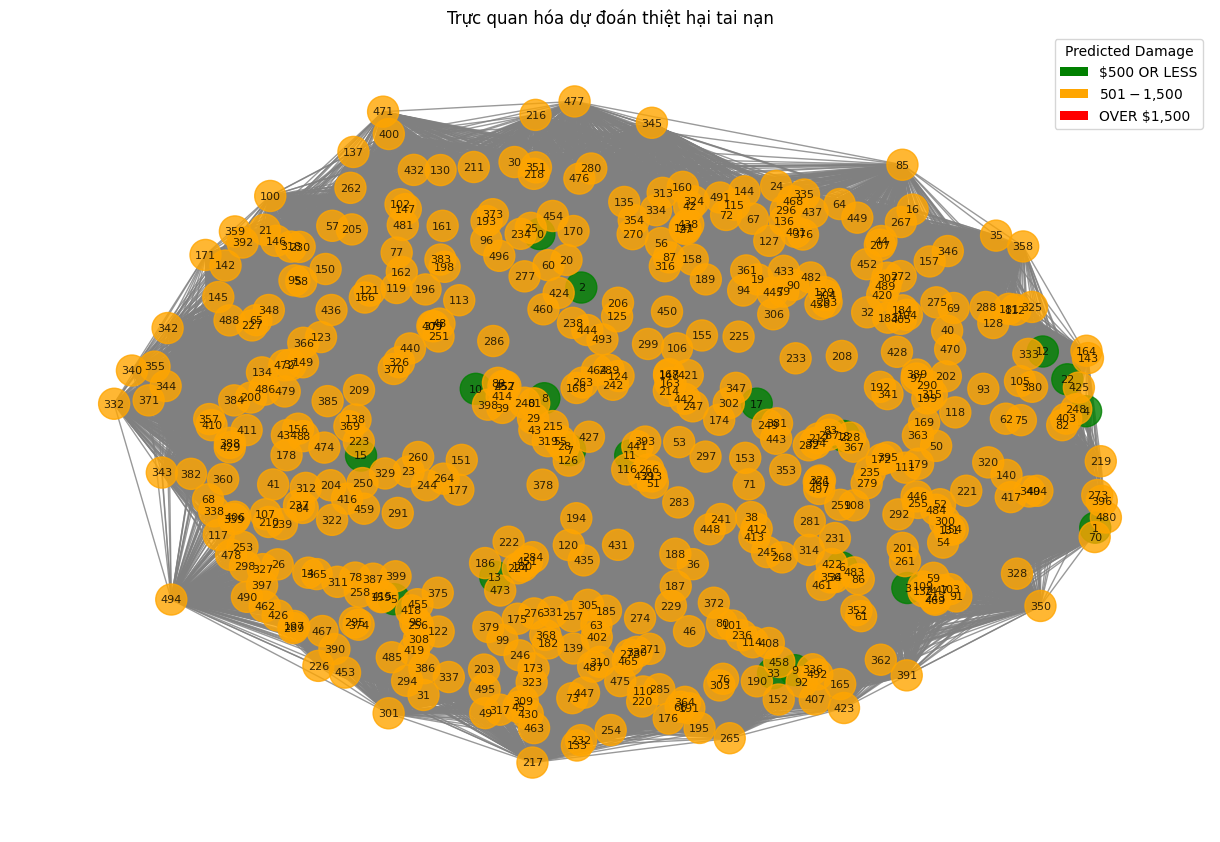

In [116]:
import matplotlib.pyplot as plt

# Gán nhãn dự đoán vào thuộc tính của node trong đồ thị
for idx, label in enumerate(df['predicted_damage']):
    G.nodes[idx]['predicted_damage'] = label

# Ánh xạ damage thành màu
color_map = {
    0: 'green',     # "$500 OR LESS"
    1: 'orange',    # "$501 - $1,500"
    2: 'red'        # "OVER $1,500"
}

# Tạo danh sách màu cho mỗi node
node_colors = [color_map[G.nodes[n]['predicted_damage']] for n in G.nodes]

# Tùy chọn: giảm số lượng node để dễ hiển thị (ví dụ chỉ 50 nodes)
sub_nodes = list(G.nodes)[:500]
subgraph = G.subgraph(sub_nodes)

# Vẽ đồ thị con với màu
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # layout đẹp hơn
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_color=[color_map[G.nodes[n]['predicted_damage']] for n in subgraph.nodes],
    node_size=500,
    font_size=8,
    edge_color='gray',
    alpha=0.8
)
# Tạo chú thích
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='$500 OR LESS'),
    Patch(facecolor='orange', label='$501 - $1,500'),
    Patch(facecolor='red', label='OVER $1,500'),
]
plt.legend(handles=legend_elements, title="Predicted Damage", loc='best')
plt.title("Trực quan hóa dự đoán thiệt hại tai nạn")
plt.axis('off')
plt.show()


Kết quả đánh giá ROC-AUC:
Lớp 0 ($500 OR LESS): 0.5572
Lớp 1 ($501 - $1,500): 0.5286
Lớp 2 (OVER $1,500): 0.5000
Trung bình: 0.5286


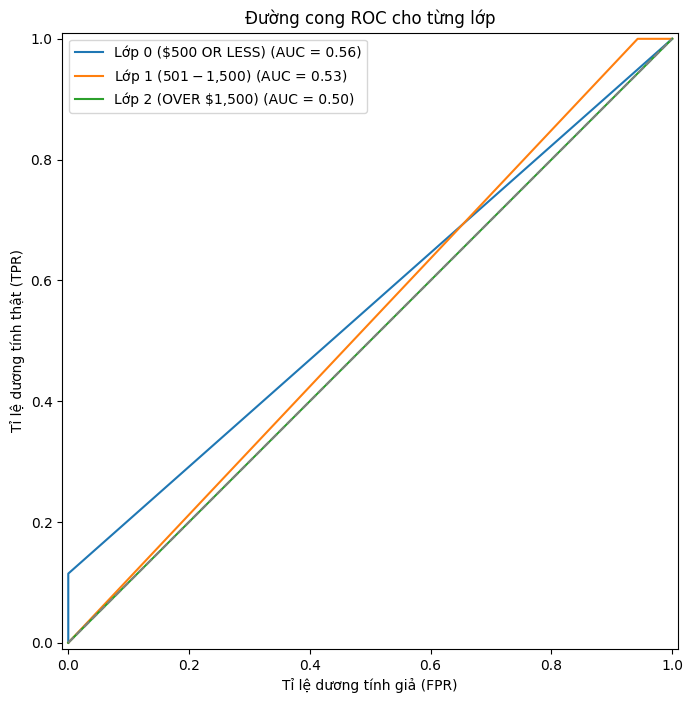

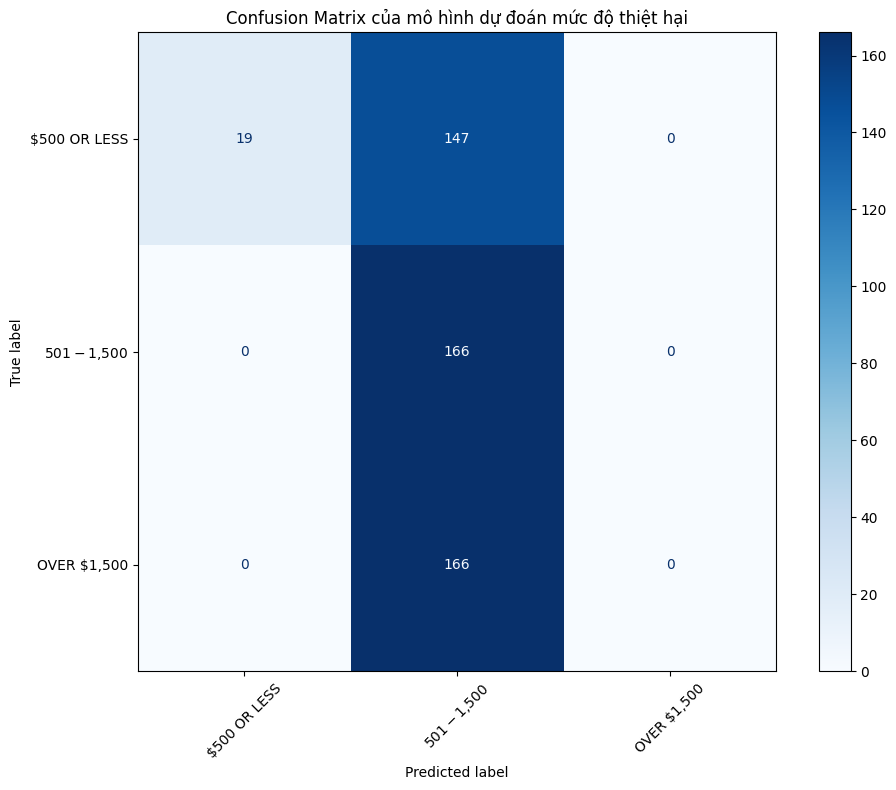


Phân tích Confusion Matrix:
- Độ chính xác cho $500 OR LESS: 11.45% (19/166)
- Độ chính xác cho $501 - $1,500: 100.00% (166/166)
- Độ chính xác cho OVER $1,500: 0.00% (0/166)

Báo cáo phân loại chi tiết:
               precision    recall  f1-score   support

 $500 OR LESS       1.00      0.11      0.21       166
$501 - $1,500       0.35      1.00      0.51       166
  OVER $1,500       0.00      0.00      0.00       166

     accuracy                           0.37       498
    macro avg       0.45      0.37      0.24       498
 weighted avg       0.45      0.37      0.24       498



c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Giả sử chúng ta có:
# - true_labels: nhãn thực tế (giá trị gốc từ cột 'damage')
# - df['predicted_damage']: dự đoán từ mô hình (đã được ánh xạ thành 0,1,2)

# Chuyển true_labels từ chuỗi sang số
damage_mapping = {
    '$500 OR LESS': 0,
    '$501 - $1,500': 1,
    'OVER $1,500': 2
}

# Chuyển đổi nhãn thực tế và dự đoán
true_labels_encoded = np.array([damage_mapping[label] for label in true_labels])
y_pred = df['predicted_damage'].values  # Đã là 0,1,2

# Binarize các nhãn cho ROC-AUC (cần cho multi-class)
y_true_bin = label_binarize(true_labels_encoded, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Tính ROC-AUC cho từng lớp và trung bình
roc_auc_scores = {}
for i in range(3):
    roc_auc_scores[f"Lớp {i} ({list(damage_mapping.keys())[i]})"] = roc_auc_score(
        y_true_bin[:, i], 
        y_pred_bin[:, i]
    )
roc_auc_scores["Trung bình"] = roc_auc_score(
    y_true_bin, 
    y_pred_bin, 
    multi_class='ovr', 
    average='macro'
)

# In kết quả ROC-AUC
print("\nKết quả đánh giá ROC-AUC:")
for k, v in roc_auc_scores.items():
    print(f"{k}: {v:.4f}")

# Trực quan hóa ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(3):
    RocCurveDisplay.from_predictions(
        y_true_bin[:, i],
        y_pred_bin[:, i],
        name=f"Lớp {i} ({list(damage_mapping.keys())[i]})",
        ax=ax
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Đường cong ROC cho từng lớp')
plt.xlabel('Tỉ lệ dương tính giả (FPR)')
plt.ylabel('Tỉ lệ dương tính thật (TPR)')
plt.legend()
plt.show()

# Tính và hiển thị Confusion Matrix
cm = confusion_matrix(true_labels_encoded, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(damage_mapping.keys())
)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix của mô hình dự đoán mức độ thiệt hại')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Phân tích chi tiết Confusion Matrix
print("\nPhân tích Confusion Matrix:")
for i in range(3):
    total = sum(cm[i])
    correct = cm[i,i]
    accuracy = correct / total if total > 0 else 0
    print(f"- Độ chính xác cho {list(damage_mapping.keys())[i]}: {accuracy:.2%} ({correct}/{total})")

# Tính các chỉ số precision, recall, F1
print("\nBáo cáo phân loại chi tiết:")
print(classification_report(
    true_labels_encoded, 
    y_pred, 
    target_names=list(damage_mapping.keys())
))

In [118]:
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate
import pandas as pd

# Tính độ chính xác tổng thể
overall_accuracy = accuracy_score(true_labels_encoded, y_pred)

print("\n==============================================")
print(f"ĐỘ CHÍNH XÁC TỔNG THỂ CỦA MÔ HÌNH: {overall_accuracy:.2%}")
print("==============================================\n")

# Lấy báo cáo phân loại và chuyển sang dictionary
report = classification_report(
    true_labels_encoded, 
    y_pred, 
    target_names=list(damage_mapping.keys()),
    output_dict=True
)

# Hiển thị bảng tóm tắt các chỉ số đánh giá
metrics_table = []
for i, class_name in enumerate(damage_mapping.keys()):
    metrics_table.append([
        class_name,
        f"{report[class_name]['precision']:.2%}",
        f"{report[class_name]['recall']:.2%}",
        f"{report[class_name]['f1-score']:.2%}",
        report[class_name]['support']
    ])

# Thêm dòng tổng hợp
metrics_table.append([
    "MACRO AVG",
    f"{report['macro avg']['precision']:.2%}",
    f"{report['macro avg']['recall']:.2%}",
    f"{report['macro avg']['f1-score']:.2%}",
    report['macro avg']['support']
])

metrics_table.append([
    "WEIGHTED AVG",
    f"{report['weighted avg']['precision']:.2%}",
    f"{report['weighted avg']['recall']:.2%}",
    f"{report['weighted avg']['f1-score']:.2%}",
    report['weighted avg']['support']
])

print(tabulate(metrics_table, 
               headers=["Lớp", "Precision", "Recall", "F1-Score", "Số lượng mẫu"],
               tablefmt="grid",
               stralign="center",
               numalign="center"))

print("\nGhi chú:")
print("- Precision: Tỉ lệ dự đoán đúng trong tất cả các dự đoán thuộc lớp đó")
print("- Recall: Tỉ lệ mẫu thuộc lớp đó được dự đoán đúng")
print("- F1-Score: Trung bình điều hòa của Precision và Recall")
print("- Macro Avg: Trung bình đơn giản của các chỉ số")
print("- Weighted Avg: Trung bình có trọng số theo số lượng mẫu")

# Phân tích thêm về các trường hợp phân loại sai
error_analysis = pd.DataFrame({
    'Thực tế': [list(damage_mapping.keys())[x] for x in true_labels_encoded],
    'Dự đoán': [list(damage_mapping.keys())[x] for x in y_pred],
    'Đúng/Sai': true_labels_encoded == y_pred
})

error_cases = error_analysis[error_analysis['Đúng/Sai'] == False]
print("\n\nPHÂN TÍCH LỖI:")
print(f"Tổng số mẫu bị phân loại sai: {len(error_cases)}/{len(df)} ({len(error_cases)/len(df):.2%})")

# Ma trận nhầm lẫn giữa các lớp
confusion_pairs = error_cases.groupby(['Thực tế', 'Dự đoán']).size().unstack().fillna(0)
print("\nCHI TIẾT NHẦM LẪN GIỮA CÁC LỚP:")
print(confusion_pairs.to_string())

# Phân phối lớp
class_distribution = pd.Series([list(damage_mapping.keys())[x] for x in true_labels_encoded]).value_counts(normalize=True)
print("\nPHÂN PHỐI LỚP TRONG DỮ LIỆU:")
print(class_distribution.to_string())


ĐỘ CHÍNH XÁC TỔNG THỂ CỦA MÔ HÌNH: 37.15%

+---------------+-------------+----------+------------+----------------+
|      Lớp      |  Precision  |  Recall  |  F1-Score  |  Số lượng mẫu  |
+===============+=============+==========+============+================+
| $500 OR LESS  |   100.00%   |  11.45%  |   20.54%   |      166       |
+---------------+-------------+----------+------------+----------------+
| $501 - $1,500 |   34.66%    | 100.00%  |   51.47%   |      166       |
+---------------+-------------+----------+------------+----------------+
|  OVER $1,500  |    0.00%    |  0.00%   |   0.00%    |      166       |
+---------------+-------------+----------+------------+----------------+
|   MACRO AVG   |   44.89%    |  37.15%  |   24.00%   |      498       |
+---------------+-------------+----------+------------+----------------+
| WEIGHTED AVG  |   44.89%    |  37.15%  |   24.00%   |      498       |
+---------------+-------------+----------+------------+----------------+

Ghi ch

c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo